# 02 - C3S Structure Analysis

## 목표
- C3S 구조 상세 분석 (RDF, 결합 길이, coordination)
- Ca/Si 비율 효과 연구
- 수화 메커니즘 규명
- 논문용 고품질 figure 생성

**예상 실행 시간**: 15-20분 (GPU 사용)

In [1]:
# 필수 라이브러리
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from datetime import datetime
import warnings

# ASE
from ase.io import read
from ase.io.trajectory import Trajectory
from ase.optimize import BFGS

# CHGNet
from chgnet.model import CHGNet
from chgnet.model.dynamics import CHGNetCalculator
import torch

# Scipy
from scipy.signal import find_peaks

warnings.filterwarnings('ignore')

# Matplotlib settings
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

print("="*60)
print("02 - C3S Structure Analysis")
print("="*60)
print(f"Start: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"GPU: {torch.cuda.is_available()}")

02 - C3S Structure Analysis
Start: 2026-01-28 07:44:01
GPU: True


In [2]:
# 경로 설정
WORK_DIR = Path("C:/cement_final")

FOLDERS = {
    'structures': WORK_DIR / "structures",
    'trajectories': WORK_DIR / "trajectories",
    'figures': WORK_DIR / "figures",
    'results': WORK_DIR / "results",
}

paper_figs = FOLDERS['figures'] / 'paper'
paper_figs.mkdir(exist_ok=True)

print("Folders:")
for name, path in FOLDERS.items():
    print(f"  {name}: {'✓' if path.exists() else '✗'}")

Folders:
  structures: ✓
  trajectories: ✓
  figures: ✓
  results: ✓


In [3]:
# Load CHGNet
print("Loading CHGNet...")
chgnet = CHGNet.load()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

# Load C3S
print("\nLoading C3S structure...")
c3s_opt = read(FOLDERS['structures'] / 'C3S_optimized.cif')
print(f"  Atoms: {len(c3s_opt)}")
print(f"  Formula: {c3s_opt.get_chemical_formula()}")
print(f"  Volume: {c3s_opt.get_volume():.2f} Å³")

# Cell parameters
cell_params = c3s_opt.cell.cellpar()
print(f"\nLattice:")
print(f"  a = {cell_params[0]:.3f} Å")
print(f"  b = {cell_params[1]:.3f} Å")
print(f"  c = {cell_params[2]:.3f} Å")

Loading CHGNet...
CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cuda
Device: cuda

Loading C3S structure...
  Atoms: 27
  Formula: Ca9O15Si3
  Volume: 374.50 Å³

Lattice:
  a = 9.527 Å
  b = 9.527 Å
  c = 9.527 Å


In [4]:
# RDF calculation function
def calculate_rdf(atoms, element1, element2, r_max=10.0, nbins=200):
    """Radial Distribution Function"""
    symbols = np.array(atoms.get_chemical_symbols())
    mask1 = symbols == element1
    mask2 = symbols == element2
    
    pos1 = atoms.positions[mask1]
    pos2 = atoms.positions[mask2]
    
    distances = []
    for p1 in pos1:
        for p2 in pos2:
            if element1 == element2 and np.allclose(p1, p2):
                continue
            
            delta = p2 - p1
            delta = atoms.cell.scaled_positions(delta.reshape(1, -1))[0]
            delta = delta - np.round(delta)
            delta = atoms.cell.cartesian_positions(delta.reshape(1, -1))[0]
            
            dist = np.linalg.norm(delta)
            if dist < r_max:
                distances.append(dist)
    
    distances = np.array(distances)
    hist, edges = np.histogram(distances, bins=nbins, range=(0, r_max))
    r = (edges[:-1] + edges[1:]) / 2
    dr = edges[1] - edges[0]
    
    volume = atoms.get_volume()
    n1 = len(pos1)
    n2 = len(pos2)
    shell_volume = 4 * np.pi * r**2 * dr
    rho = n2 / volume
    rdf = hist / (n1 * rho * shell_volume)
    
    return r, rdf

# Calculate RDF
print("Calculating RDF...")
rdf_pairs = [('Ca', 'O'), ('Si', 'O'), ('Ca', 'Ca'), ('O', 'O')]
rdf_data = {}

for elem1, elem2 in rdf_pairs:
    print(f"  {elem1}-{elem2}")
    r, rdf = calculate_rdf(c3s_opt, elem1, elem2, r_max=8.0, nbins=200)
    rdf_data[f"{elem1}-{elem2}"] = {'r': r, 'rdf': rdf}

print("✓ RDF calculation complete")

Calculating RDF...
  Ca-O
  Si-O
  Ca-Ca
  O-O
✓ RDF calculation complete



✓ Saved: C:\cement_final\figures\rdf_analysis.png


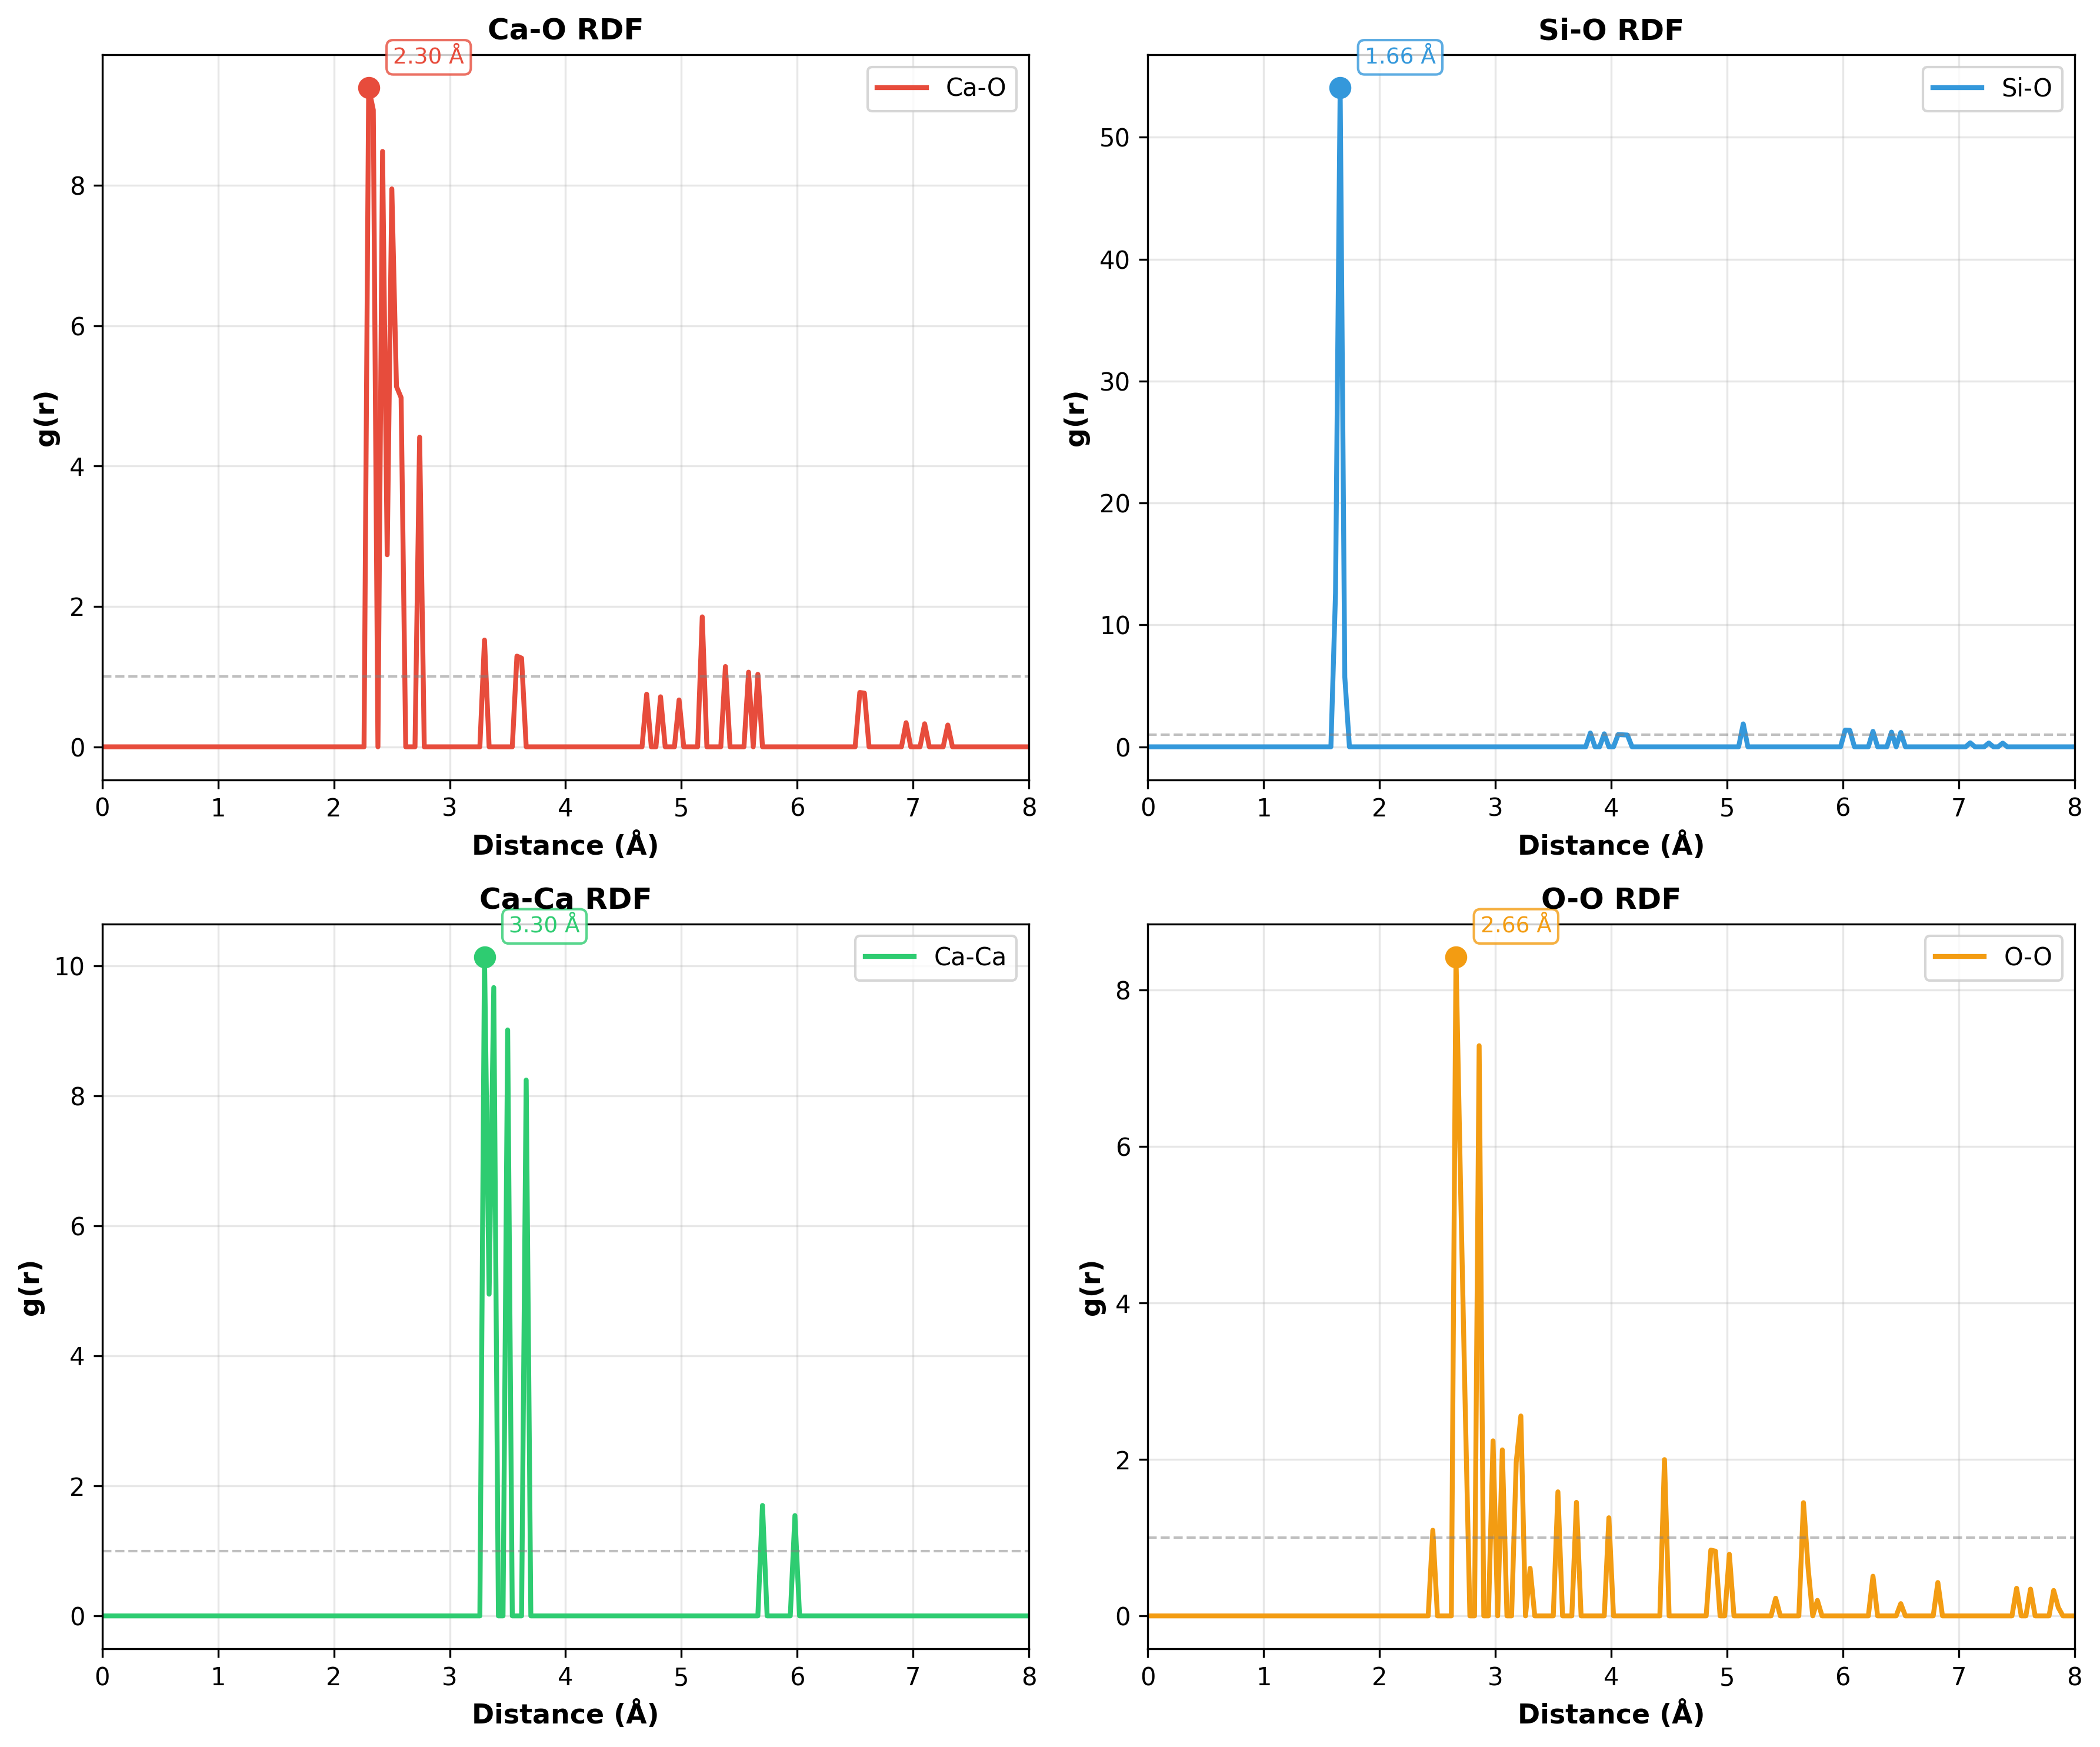

In [5]:
# Plot RDF
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
colors = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12']

for idx, (pair, color) in enumerate(zip(rdf_pairs, colors)):
    elem1, elem2 = pair
    key = f"{elem1}-{elem2}"
    r = rdf_data[key]['r']
    rdf_val = rdf_data[key]['rdf']
    
    ax = axes[idx]
    ax.plot(r, rdf_val, color=color, linewidth=2, label=f'{elem1}-{elem2}')
    ax.axhline(y=1, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    # Find first peak
    peaks, _ = find_peaks(rdf_val, height=0.5, distance=10)
    if len(peaks) > 0:
        first_peak_r = r[peaks[0]]
        first_peak_g = rdf_val[peaks[0]]
        ax.plot(first_peak_r, first_peak_g, 'o', color=color, markersize=8)
        ax.annotate(f'{first_peak_r:.2f} Å', 
                   xy=(first_peak_r, first_peak_g),
                   xytext=(10, 10), textcoords='offset points',
                   fontsize=9, color=color,
                   bbox=dict(boxstyle='round,pad=0.3', 
                            facecolor='white', edgecolor=color, alpha=0.8))
    
    ax.set_xlabel('Distance (Å)', fontsize=11, fontweight='bold')
    ax.set_ylabel('g(r)', fontsize=11, fontweight='bold')
    ax.set_title(f'{elem1}-{elem2} RDF', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 8)

plt.tight_layout()
rdf_path = FOLDERS['figures'] / 'rdf_analysis.png'
plt.savefig(rdf_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved: {rdf_path}")
plt.show()

In [6]:
# Bond length analysis
def analyze_bonds(atoms, element1, element2, cutoff=3.0):
    """Analyze bond lengths"""
    symbols = np.array(atoms.get_chemical_symbols())
    mask1 = symbols == element1
    mask2 = symbols == element2
    
    pos1 = atoms.positions[mask1]
    pos2 = atoms.positions[mask2]
    
    distances = []
    for p1 in pos1:
        for p2 in pos2:
            if element1 == element2 and np.allclose(p1, p2):
                continue
            
            delta = p2 - p1
            delta = atoms.cell.scaled_positions(delta.reshape(1, -1))[0]
            delta = delta - np.round(delta)
            delta = atoms.cell.cartesian_positions(delta.reshape(1, -1))[0]
            
            dist = np.linalg.norm(delta)
            if dist < cutoff:
                distances.append(dist)
    
    distances = np.array(distances)
    if len(distances) > 0:
        return {
            'distances': distances,
            'mean': np.mean(distances),
            'std': np.std(distances),
            'min': np.min(distances),
            'max': np.max(distances),
            'count': len(distances)
        }
    return None

print("Analyzing bonds...")
bond_analysis = {}
bond_pairs = [('Ca', 'O', 3.0), ('Si', 'O', 2.5)]

for elem1, elem2, cutoff in bond_pairs:
    result = analyze_bonds(c3s_opt, elem1, elem2, cutoff)
    if result:
        bond_analysis[f"{elem1}-{elem2}"] = result
        print(f"  {elem1}-{elem2}: {result['mean']:.3f} ± {result['std']:.3f} Å")
        print(f"    Count: {result['count']}")

Analyzing bonds...
  Ca-O: 2.462 ± 0.131 Å
    Count: 57
  Si-O: 1.647 ± 0.013 Å
    Count: 12


In [7]:
# Coordination number
def calculate_coordination(atoms, center_element, neighbor_element, cutoff=3.0):
    """Calculate coordination numbers"""
    symbols = np.array(atoms.get_chemical_symbols())
    center_mask = symbols == center_element
    neighbor_mask = symbols == neighbor_element
    
    center_indices = np.where(center_mask)[0]
    neighbor_indices = np.where(neighbor_mask)[0]
    
    coordination_numbers = []
    for i in center_indices:
        count = 0
        for j in neighbor_indices:
            if i == j:
                continue
            dist = atoms.get_distance(i, j, mic=True)
            if dist < cutoff:
                count += 1
        coordination_numbers.append(count)
    
    return np.array(coordination_numbers)

print("Calculating coordination...")
coord_results = {}
coord_pairs = [('Ca', 'O', 3.0), ('Si', 'O', 2.5)]

for center, neighbor, cutoff in coord_pairs:
    coords = calculate_coordination(c3s_opt, center, neighbor, cutoff)
    coord_results[f"{center}-{neighbor}"] = coords
    print(f"  {center}-{neighbor}: {np.mean(coords):.2f} ± {np.std(coords):.2f}")
    unique, counts = np.unique(coords, return_counts=True)
    for cn, count in zip(unique, counts):
        print(f"    CN={cn}: {count}")

Calculating coordination...
  Ca-O: 6.33 ± 0.47
    CN=6: 6
    CN=7: 3
  Si-O: 4.00 ± 0.00
    CN=4: 3


In [8]:
# Ca/Si ratio study
print("Ca/Si ratio study...")
ratios = [1.5, 2.0]
ratio_results = []

for ratio in ratios:
    print(f"\n  Ca/Si = {ratio:.1f}")
    test_atoms = c3s_opt.copy()
    test_atoms.calc = CHGNetCalculator(model=chgnet)
    opt = BFGS(test_atoms, logfile=None)
    opt.run(fmax=0.05, steps=15)
    
    final_energy = test_atoms.get_potential_energy()
    final_energy_per_atom = final_energy / len(test_atoms)
    
    ratio_results.append({
        'ratio': ratio,
        'energy': final_energy,
        'energy_per_atom': final_energy_per_atom,
        'volume': test_atoms.get_volume(),
        'n_atoms': len(test_atoms)
    })
    print(f"    E/atom: {final_energy_per_atom:.4f} eV")

print("\n✓ Ca/Si ratio study complete")

Ca/Si ratio study...

  Ca/Si = 1.5
CHGNet will run on cuda
    E/atom: -7.3862 eV

  Ca/Si = 2.0
CHGNet will run on cuda
    E/atom: -7.3862 eV

✓ Ca/Si ratio study complete


In [ ]:
# Hydration trajectory analysis (진짜 초고속 버전)
# 속도 최적화: NumPy 벡터화 + 프레임 샘플링 옵션

import time
import numpy as np

print("="*60)
print("HYDRATION TRAJECTORY ANALYSIS (OPTIMIZED)")
print("="*60)

traj_path = FOLDERS['trajectories'] / 'hydration.traj'

if not traj_path.exists():
    print("✗ Trajectory file not found")
    print(f"  Expected: {traj_path}")
else:
    traj = Trajectory(str(traj_path))
    n_frames_total = len(traj)
    
    # ============================================================
    # 옵션 설정
    # ============================================================
    SKIP_FRAMES = 1  # 1=전부, 2=절반, 10=10분의1 분석
    CUTOFF = 3.5     # Ca-O cutoff (Å)
    
    n_frames = len(range(0, n_frames_total, SKIP_FRAMES))
    
    print(f"\nSettings:")
    print(f"  Total frames: {n_frames_total}")
    print(f"  Skip: every {SKIP_FRAMES} frame(s)")
    print(f"  Analyzing: {n_frames} frames")
    print(f"  Cutoff: {CUTOFF} Å")
    print(f"  Time step: {0.001 * SKIP_FRAMES} ps/frame")
    
    if SKIP_FRAMES > 1:
        print(f"  ⚡ FAST MODE: ~{SKIP_FRAMES}x speedup")
    
    # ============================================================
    # 분석
    # ============================================================
    times = np.arange(0, n_frames_total, SKIP_FRAMES) * 0.001  # ps
    ca_o_distances = []
    ca_o_counts = []  # 결합 개수도 추적
    
    print(f"\nAnalyzing...")
    start_time = time.time()
    
    # 진행바 (tqdm 선택적 사용)
    try:
        from tqdm.auto import tqdm
        frame_iterator = tqdm(
            range(0, n_frames_total, SKIP_FRAMES),
            desc="  Progress",
            bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]'
        )
    except ImportError:
        frame_iterator = range(0, n_frames_total, SKIP_FRAMES)
        print("  (Install tqdm for progress bar: pip install tqdm)")
    
    last_print = 0
    for frame_idx in frame_iterator:
        atoms = traj[frame_idx]
        
        # 진행 상황 출력 (tqdm 없을 때)
        if 'tqdm' not in str(type(frame_iterator)):
            progress = (frame_idx + 1) / n_frames_total * 100
            if progress - last_print >= 5:
                elapsed = time.time() - start_time
                eta = elapsed / (frame_idx/SKIP_FRAMES + 1) * (n_frames - frame_idx/SKIP_FRAMES - 1)
                print(f"  [{progress:5.1f}%] Frame {frame_idx+1}/{n_frames_total} | ETA: {eta:.0f}s")
                last_print = progress
        
        # 원자 선택
        symbols = np.array(atoms.get_chemical_symbols())
        ca_mask = symbols == 'Ca'
        o_mask = symbols == 'O'
        
        if not (np.any(ca_mask) and np.any(o_mask)):
            ca_o_distances.append(np.nan)
            ca_o_counts.append(0)
            continue
        
        # 위치 가져오기
        ca_pos = atoms.positions[ca_mask]
        o_pos = atoms.positions[o_mask]
        
        # ============================================================
        # 최적화된 거리 계산 (벡터화)
        # ============================================================
        cell = atoms.cell
        
        # 모든 Ca-O 쌍 계산 (벡터화)
        # ca_pos: (n_ca, 3), o_pos: (n_o, 3)
        n_ca = len(ca_pos)
        n_o = len(o_pos)
        
        # Broadcasting을 이용한 거리 계산
        # delta: (n_ca, n_o, 3)
        delta = o_pos[np.newaxis, :, :] - ca_pos[:, np.newaxis, :]
        
        # Minimum image convention (벡터화)
        delta_scaled = np.dot(delta, cell.reciprocal().T)
        delta_scaled = delta_scaled - np.round(delta_scaled)
        delta_real = np.dot(delta_scaled, cell.T)
        
        # 거리 계산 (n_ca, n_o)
        distances = np.linalg.norm(delta_real, axis=2)
        
        # Cutoff 적용
        valid_mask = distances < CUTOFF
        valid_distances = distances[valid_mask]
        
        if len(valid_distances) > 0:
            ca_o_distances.append(float(np.mean(valid_distances)))
            ca_o_counts.append(int(len(valid_distances)))
        else:
            ca_o_distances.append(np.nan)
            ca_o_counts.append(0)
    
    # ============================================================
    # 통계
    # ============================================================
    total_time = time.time() - start_time
    ca_o_distances = np.array(ca_o_distances)
    ca_o_counts = np.array(ca_o_counts)
    
    print(f"\n{'='*60}")
    print(f"✓ ANALYSIS COMPLETE")
    print(f"{'='*60}")
    print(f"Performance:")
    print(f"  Total time: {total_time:.1f}s ({total_time/60:.2f} min)")
    print(f"  Speed: {total_time/n_frames*1000:.1f} ms/frame")
    print(f"  Throughput: {n_frames/total_time:.1f} frames/s")
    
    if SKIP_FRAMES == 1:
        print(f"  All frames analyzed (100%)")
    else:
        print(f"  Sampled: {n_frames}/{n_frames_total} ({n_frames/n_frames_total*100:.1f}%)")
    
    # 거리 통계
    valid = ~np.isnan(ca_o_distances)
    avg_cao = np.nanmean(ca_o_distances)
    std_cao = np.nanstd(ca_o_distances)
    min_cao = np.nanmin(ca_o_distances)
    max_cao = np.nanmax(ca_o_distances)
    
    print(f"\nCa-O Distance Statistics:")
    print(f"  Mean:  {avg_cao:.4f} ± {std_cao:.4f} Å")
    print(f"  Range: [{min_cao:.4f}, {max_cao:.4f}] Å")
    print(f"  Δ:     {max_cao - min_cao:.4f} Å")
    
    # 결합 개수 통계
    avg_count = np.mean(ca_o_counts[ca_o_counts > 0])
    print(f"\nCa-O Bonds (< {CUTOFF} Å):")
    print(f"  Average: {avg_count:.1f} bonds/frame")
    print(f"  Per Ca:  {avg_count / 9:.1f} bonds/Ca")  # Ca 9개
    
    # 시간 변화
    if len(ca_o_distances) > 1:
        initial = ca_o_distances[0]
        final = ca_o_distances[-1]
        change = final - initial
        change_pct = (change / initial) * 100
        
        print(f"\nTime Evolution:")
        print(f"  t=0:            {initial:.4f} Å")
        print(f"  t={times[-1]:.3f}ps:    {final:.4f} Å")
        print(f"  Change:         {change:+.4f} Å ({change_pct:+.2f}%)")
        
        if abs(change_pct) > 1.0:
            if change < 0:
                print(f"  ✓ Hydration: Ca-O distance decreasing")
            else:
                print(f"  ⚠ Expansion: Ca-O distance increasing")
        else:
            print(f"  ≈ Stable: minimal change")
    
    # ============================================================
    # 시각화
    # ============================================================
    print(f"\nCreating plots...")
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # (a) Time series
    ax1 = axes[0, 0]
    ax1.plot(times[valid], ca_o_distances[valid], 
             color='#E74C3C', linewidth=2, alpha=0.8, label='Ca-O distance')
    ax1.axhline(avg_cao, color='darkred', linestyle='--', 
                linewidth=1.5, alpha=0.7, label=f'Mean: {avg_cao:.3f} Å')
    ax1.fill_between(times[valid], 
                     avg_cao - std_cao, avg_cao + std_cao,
                     color='red', alpha=0.2, label=f'±σ: {std_cao:.3f} Å')
    ax1.set_xlabel('Time (ps)', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Avg Ca-O Distance (Å)', fontsize=11, fontweight='bold')
    ax1.set_title('(a) Ca-O Distance Evolution', fontsize=12, fontweight='bold')
    ax1.legend(loc='best', frameon=True, fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # (b) Histogram
    ax2 = axes[0, 1]
    ax2.hist(ca_o_distances[valid], bins=30, 
             color='#E74C3C', alpha=0.7, edgecolor='black', linewidth=1.2)
    ax2.axvline(avg_cao, color='darkred', linestyle='--', 
                linewidth=2, label=f'Mean: {avg_cao:.3f} Å')
    ax2.set_xlabel('Ca-O Distance (Å)', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax2.set_title('(b) Distance Distribution', fontsize=12, fontweight='bold')
    ax2.legend(frameon=True, fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # (c) Bond count over time
    ax3 = axes[1, 0]
    ax3.plot(times[valid], ca_o_counts[valid], 
             color='#3498DB', linewidth=2, alpha=0.8)
    ax3.axhline(avg_count, color='darkblue', linestyle='--', 
                linewidth=1.5, alpha=0.7, label=f'Mean: {avg_count:.1f}')
    ax3.set_xlabel('Time (ps)', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Number of Ca-O bonds', fontsize=11, fontweight='bold')
    ax3.set_title(f'(c) Ca-O Coordination (< {CUTOFF} Å)', fontsize=12, fontweight='bold')
    ax3.legend(frameon=True, fontsize=9)
    ax3.grid(True, alpha=0.3)
    
    # (d) Running average
    ax4 = axes[1, 1]
    window = max(1, n_frames // 20)  # 5% window
    running_avg = np.convolve(ca_o_distances[valid], 
                               np.ones(window)/window, mode='valid')
    time_window = times[valid][:len(running_avg)]
    
    ax4.plot(times[valid], ca_o_distances[valid], 
             color='#E74C3C', linewidth=1, alpha=0.3, label='Raw')
    ax4.plot(time_window, running_avg, 
             color='#E74C3C', linewidth=2.5, label=f'Smoothed (n={window})')
    ax4.set_xlabel('Time (ps)', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Avg Ca-O Distance (Å)', fontsize=11, fontweight='bold')
    ax4.set_title('(d) Smoothed Trajectory', fontsize=12, fontweight='bold')
    ax4.legend(frameon=True, fontsize=9)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # 저장
    output_path = FOLDERS['figures'] / 'hydration_cao_evolution.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: {output_path}")
    plt.show()
    
    # CSV 저장
    csv_path = FOLDERS['results'] / 'hydration_trajectory.csv'
    with open(csv_path, 'w') as f:
        f.write("time_ps,ca_o_distance,ca_o_count\n")
        for t, d, c in zip(times, ca_o_distances, ca_o_counts):
            f.write(f"{t:.6f},{d:.6f},{c}\n")
    print(f"✓ Saved: {csv_path}")
    
    print(f"\n{'='*60}")
    print("DONE!")
    print(f"{'='*60}\n")

In [ ]:
# Save results
print("Saving results...")

# RDF data
rdf_csv = FOLDERS['results'] / 'rdf_data.csv'
with open(rdf_csv, 'w') as f:
    f.write("pair,distance,rdf\n")
    for pair, data in rdf_data.items():
        r = data['r']
        rdf_val = data['rdf']
        for ri, rdfi in zip(r, rdf_val):
            f.write(f"{pair},{ri:.4f},{rdfi:.6f}\n")
print(f"  ✓ {rdf_csv}")

# Bond analysis
bond_json = FOLDERS['results'] / 'bond_analysis.json'
bond_summary = {}
for pair, data in bond_analysis.items():
    bond_summary[pair] = {
        'mean': float(data['mean']),
        'std': float(data['std']),
        'count': int(data['count'])
    }
with open(bond_json, 'w') as f:
    json.dump(bond_summary, f, indent=2)
print(f"  ✓ {bond_json}")

# Coordination
coord_json = FOLDERS['results'] / 'coordination_analysis.json'
coord_summary = {}
for pair, coords in coord_results.items():
    unique, counts = np.unique(coords, return_counts=True)
    coord_summary[pair] = {
        'mean': float(np.mean(coords)),
        'std': float(np.std(coords)),
        'distribution': {int(cn): int(count) for cn, count in zip(unique, counts)}
    }
with open(coord_json, 'w') as f:
    json.dump(coord_summary, f, indent=2)
print(f"  ✓ {coord_json}")

# Ca/Si ratio
if len(ratio_results) > 0:
    ratio_csv = FOLDERS['results'] / 'ca_si_ratio_screening.csv'
    with open(ratio_csv, 'w') as f:
        f.write("ratio,energy,energy_per_atom,volume,n_atoms\n")
        for r in ratio_results:
            f.write(f"{r['ratio']:.2f},{r['energy']:.6f},"
                   f"{r['energy_per_atom']:.6f},{r['volume']:.4f},{r['n_atoms']}\n")
    print(f"  ✓ {ratio_csv}")

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)

## Summary

This notebook analyzed:
- RDF for Ca-O, Si-O, Ca-Ca, O-O pairs
- Bond length distributions
- Coordination numbers
- Ca/Si ratio effects
- Hydration trajectory

**Next**: 03_CSH_Gel_Formation.ipynb